<a href="https://colab.research.google.com/github/synsense/snn-workshop-amld-2022/blob/master/3.%20Training%20SNNs%20from%20scratch/training_snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3 : Training Spiking Neural Networks using BPTT

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**: Ugurcan Cakal, Hannah Bos, Saeid Haghighatshoar, Dylan Muir

**Estimated duration**: 30 minutes

So far we have investigated the Integrate and Fire (IF) neuron model and trained a Convolutional Neural Network (CNN) on a body posture classification task. The CNN was converted into an Spiking Neural Network (SNN) after training. In this tutorial, we will investigate and optimize the firing rate response of a simple spiking neural network (SNN). We will define a single neuron with a single input channel and measure its mean firing rate. Specifically, we will explore:

* how to build an SNN using the Rockpool torch-backed Leaky Integrate and Fire (LIF) model (`LIFTorch`)
* how to optimize the parameters of an SNNs using Back Propagation Through Time (BPTT)
* why error backpropagation is difficult in SNNs and how it can be tackled using surrogate gradients

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/network.png width="1024">




---
# Setup

In [ ]:
%%capture
!pip install rockpool

### Imports

In [ ]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Dict, Optional, Tuple
import numpy as np
from tqdm import tqdm

# Torch Imports
import torch
from torch.nn import MSELoss
from torch.optim import Adam

# Rockpool Imports
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.modules.torch.lif_torch import StepPWL
from rockpool.nn.modules.torch.torch_module import TorchModule
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.timeseries import TSContinuous, TSEvent

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100

### Utilities

In [ ]:
# @title Data Generation { display-mode: "form" }

def poisson_spike_train(
    duration: float, rate: float, dt: float, seed: Optional[int] = None
) -> torch.Tensor:
    """
    random_spike_train generates a Poisson frozen random spike train 

    :param duration: simulation duration in seconds
    :type duration: float
    :param rate: expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: time step length
    :type dt: float, optional
    :raises ValueError: no spike generated due to low firing rate or very short simulation time]
    :return: randomly generated discrete spike train
    :rtype: torch.Tensor
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (1, steps, 1))

    # Check if raster has at least one spike
    if not any(raster.flatten()):
        raise ValueError(
            "No spike generated at all due to low firing rate or short simulation time duration!"
        )

    spike_tensor = torch.tensor(raster, dtype=torch.float)
    return spike_tensor

In [ ]:
#@title Plotting { display-mode: "form" }

_to_numpy = lambda _tensor: _tensor.detach().numpy().flatten()

def plot_signal(tensor: torch.Tensor, name: str, unit: str, dt: float) -> None:
    """
    plot_signal converts a signal to a ``TSContinuous`` object and plots the result

    :param tensor: signal with shape (batch, time_steps, n_channels)
    :type tensor: torch.Tensor
    :param name: name of the signal to be used as the title of the plot
    :type name: str
    :param unit: unit of measurement to label y axis
    :type unit: str
    :param dt: discrete time step length in seconds
    :type dt: float
    """
    Ix = TSContinuous.from_clocked(_to_numpy(tensor), dt=dt, name=name)
    plt.figure()
    plt.ylabel(unit)
    Ix.plot()

def plot_raster(tensor: torch.Tensor, name: str, dt: float) -> None:
    """
    plot_raster converts a ``spikes`` record obtained from the record dictionary to a ``TSEvent`` object and plots the result

    :param tensor: spike raster with shape (batch, time_steps, n_channels)
    :type tensor: torch.Tensor
    :param name: name of the spike raster for the title of the plot
    :type name: str
    :param dt: time step length in seconds
    :type dt: float
    """
    spikes_ts = TSEvent.from_raster(_to_numpy(tensor), dt=dt, name=name)
    plt.figure()
    spikes_ts.plot()

def plot_LIF_record(
    rec: Dict[str, torch.Tensor],
    dt: float,
    plot_Vmem: bool = True,
    plot_Isyn: bool = True,
    plot_spikes: bool = True,
    plot_Irec: bool = False,
    Vth: Optional[float] = None,
) -> None:
    """
    plot_LIF_record takes an ``LIFTorch`` record dictionary and plots the signals and the spike raster

    :param rec: ``LIFTorch`` record dictionary
    :type rec: Dict[str, torch.Tensor]
    :param dt: time step length in seconds
    :type dt: float, optional
    :param plot_Vmem: plot membrane potential or not, defaults to True
    :type plot_Vmem: bool, optional
    :param plot_Isyn: plot external synaptic current or not, defaults to True
    :type plot_Isyn: bool, optional
    :param plot_spikes: plot spiking output or not, defaults to True
    :type plot_spikes: bool, optional
    :param plot_Irec: plot recurrent synaptic current or not, defaults to False
    :type plot_Irec: bool, optional
    :param Vth: spiking threshold of the membrane potential. Plot if not None, defaults to None
    :type Vth: Optional[float], optional
    """

    # Recurrent synaptic current
    if plot_Irec:
        plot_signal(rec["irec"].detach(), "$I_{rec}$", "Current", dt)

    # External synaptic current
    if plot_Isyn:
        plot_signal(rec["isyn"].detach(), "$I_{syn}$", "Current", dt)

    # Membrane potential
    if plot_Vmem:
        vmem = rec["vmem"]
        plot_signal(vmem, "$V_{mem}$", "Voltage", dt)

        # Spike threshold
        if Vth is not None:
            _vth = np.ones_like(vmem.detach().flatten()) * Vth
            _vth = TSContinuous.from_clocked(_vth, dt=dt)
            _vth.plot(linestyle="dashed")

    # Spike output
    if plot_spikes:
        plot_raster(rec["spikes"].detach(), "Output Spikes", dt)

In [ ]:
#@title Custom Rate Readout Layer { display-mode: "form" }

class RateReadout(TorchModule):
    """
    RateReadout implements a custom layer which measures the firing rate of the upstream spiking layer

    :Output:

    .. math ::

        r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}

    :param shape: shape of the layer ``(Nin, Nout)``
    :type shape: tuple
    :param dt: time step length in seconds
    :type dt: float, optional
    :raises ValueError: `shape` must specify input and output size for RateReadout
    """

    def __init__(self, shape: Tuple[int], dt: float, *args, **kwargs) -> None:
        """
        __init__ Initialize ``RateReadout`` module. Parameters are explained in the class docstring.

        """
        super().__init__(shape=shape, *args, **kwargs)

        if len(self.shape) != 2:
            raise ValueError(
                "`shape` must specify input and output size for RateReadout."
            )

        self.dt = dt

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        """
        forward processing data through this layer, calculates the firing rate

        :param data: spike train data taking the shape of (batch, time_steps, n_synapses)
        :type data: torch.Tensor
        :return: firing rate response of the previous spiking layer with the shape of (batch, 1, n_synapses)
        :rtype: torch.Tensor
        """
        data, _ = self._auto_batch(data)

        n_batch, n_timesteps, n_channel = data.shape
        rate = torch.sum(data, axis=1) / (n_timesteps * self.dt)
        return rate

---
## Section 1: Model Implementation

We will use the following three Rockpool modules: 

`LinearTorch`, `LIFTorch`, and `RateReadout`.

Let's deep dive into the Rockpool implementation and then construct the model.

### Section 1.1 : LinearTorch

Linear layers encapsulate a weight matrix. They are analogous to `torch.nn.Linear`, and apply a linear transformation to the incoming data. In this layer the bias is optional --- we will not use it (i.e. $b = 0$).

* $S_{in}^{f}(t) = S_{in}^{b}(t) \cdot W_{in}^{T} + b $

| **TERM**            | **DEFINITION**                                                                        |
|---------------------|-------------------------------------------------------------------------------------- |
| $$S_{in}^{f}(t)$$   | float vector containing weighted spikes for each input channel                        |
| $$S_{in}^{b}(t)$$   | binary vector containing ones for each input channel that emits a spike at time $t$   |
| $$W_{in}$$          | input weight matrix                                                                   |
| $$b$$               | linear bias                                                                           |

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/linear_trans.png width="1024">

In [ ]:
# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[0.02]]),
    has_bias=False,
)

### Section 1.2 : LIFTorch
The LIF layer evaluates a set of spiking neuron dynamics, and produces a spike train as output. Here it is used instead of a state-less activation functions such as `torch.nn.ReLU`. The output of the LIF neurons does not only depend on the instantaneous inputs but also on its past inputs via its internal state $V_{mem}(t)$. The state evolves continuously over time, regardless of when the neuron receives spikes on its input. The state update of the `LIFTorch` module obeys the following equations:

1. The synaptic current input $I_{syn}$ is updated.

  * $I_{syn}(t+1) = \left(I_{syn}(t) + S_{in}(t) + \underbrace{S_{rec}(t) \cdot W_{rec}}_{I_{rec}} \right) \cdot \underbrace{\text{exp} \left( - \dfrac{dt}{\tau_{syn}} \right)}_{\text{leakage}} $

| **TERM**            | **DEFINITION**                                                                     |
|-------------------	|------------------------------------------------------------------------------------|
| $$S_{rec}(t)$$     	| vector containing $1$ for each neuron that emitted a spike in the last time-step   |
| $$W_{rec}$$     	  | recurrent weight matrix                                                            |
| $$dt$$             	| timestep  length                                                                   |
| $$\tau_{syn}$$     	| synaptic time constant                                                             |

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/exp_decay.png width="1024">

2. The membrane potential $V_{mem}$ is calculated.
    * $V_{mem}(t+1) = \left( V_{mem}(t) + I_{syn}(t) + I_b + \sigma \zeta(t) \right)  \cdot \text{exp} \left( - \dfrac{dt}{\tau_{mem}} \right)$

| **TERM**              | **DEFINITION**                                          |
|---------------------- |-------------------------------------------------------- |
| $$I_b$$          	    | bias current injected to the neuron at eact time-step   |
| $$\sigma\zeta(t)$$ 	| Wiener noise process with standard deviation $\sigma$   |
| $$\tau_{mem}$$     	| membrane time constant                                  |


3. When the membrane potential for neuron $j$ ($V_{mem, j}$) exceeds the threshold voltage $V_{th}$, the neuron emits a spike and the threshold potential is subtracted from the membrane potential.

* $V_{mem, j} > V_{thr} \rightarrow S_{rec,j} = 1$
* $V_{mem, j} = V_{mem, j} - V_{thr}$

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/membrane_potential.png width="1024">

In [ ]:
# --- LIF Layer --- #
dt = 1e-3
Vth = Constant(1.0)

lif = LIFTorch(
    shape=(1, 1),
    tau_mem=Constant(0.03),
    tau_syn=Constant(0.01),
    bias=Constant(0.0),
    threshold=Constant(1.0),
    noise_std = 0.0,
    spike_generation_fn=StepPWL,
    dt=dt,
)

### Section 1.3: RateReadout
Rate Readout layer is a custom `TorchModule`. It measures the firing rate of the upstream spiking layer. The firing rate is given by

* $r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}$

| **TERM**          | **DEFINITION**             |
|------------------	|----------------------------|
| $$r$$ 	        | firing rates of the neuron |
| $$T$$           	| simulation duraiton        |

In [ ]:
# --- Readout Layer --- #
readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

---
## Section 2: Model Investigation

We provide random spiking input and observe how the model processes this input.

### Section 2.1 : Generate Input Spike Train

Generate a random poisson spike train with a mean firing rate of 200 Hz.

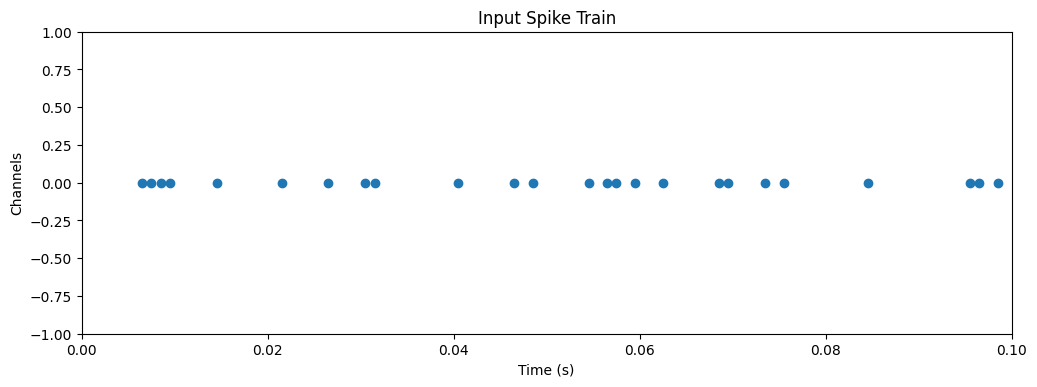

In [ ]:
spike_ts = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt, seed=2022)
plot_raster(spike_ts, "Input Spike Train", dt)

Now let's run the model and record the state changes over time

In [ ]:
# Run!
model.reset_state()
rate_out, state, record_dict = model(spike_ts, record = True)

In [ ]:
# TODO : [OPTIONAL] Explore the output of the model run
# print(rate_out)
# print(state.keys())
# print(record_dict.keys())

### Section 2.2 Observe State Evolution Over Time

The input layer performs a linear transformation of the spike train, producing weighted spikes.

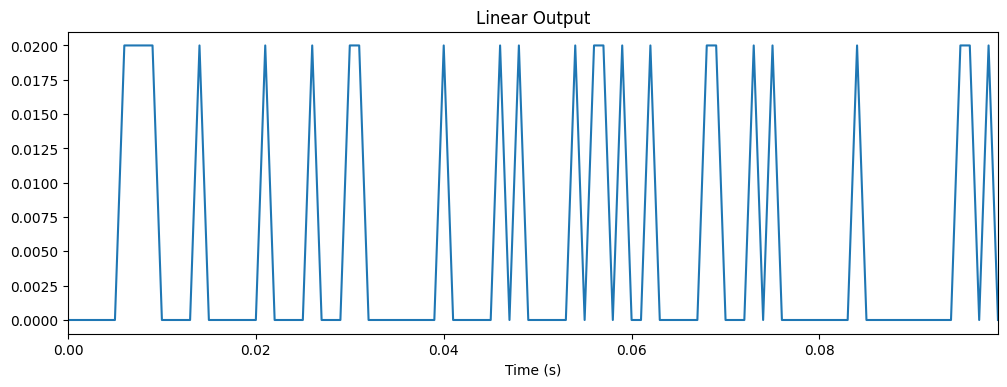

In [ ]:
plot_signal(record_dict["0_LinearTorch_output"], "Linear Output", "", dt)

The stateful LIF layer simulates the synapse and neuron membrane dynamics. We can observe the time evolution of the
* synaptic current $I_{syn}$ 
* membrane potential $V_{mem}$ 
* output spikes

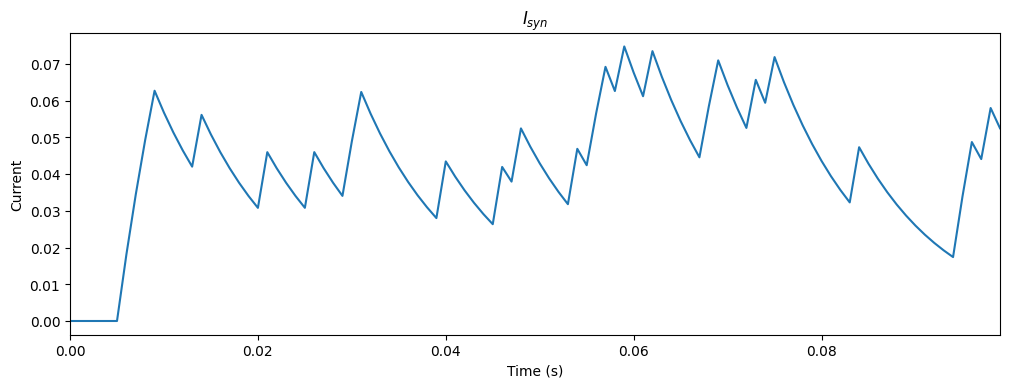

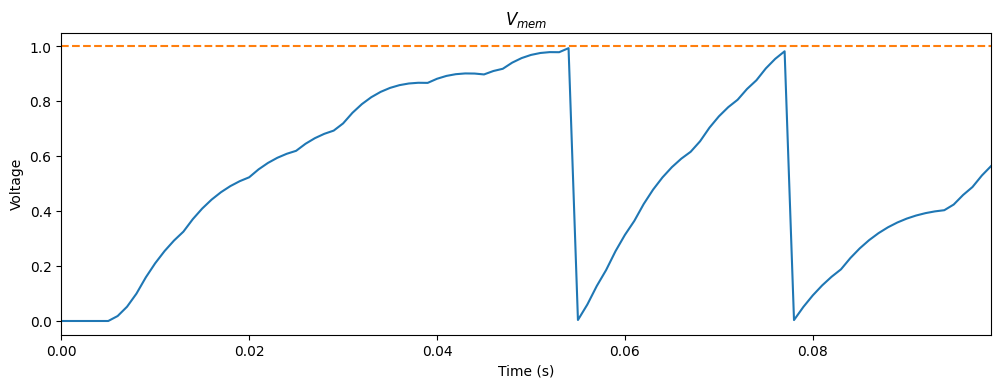

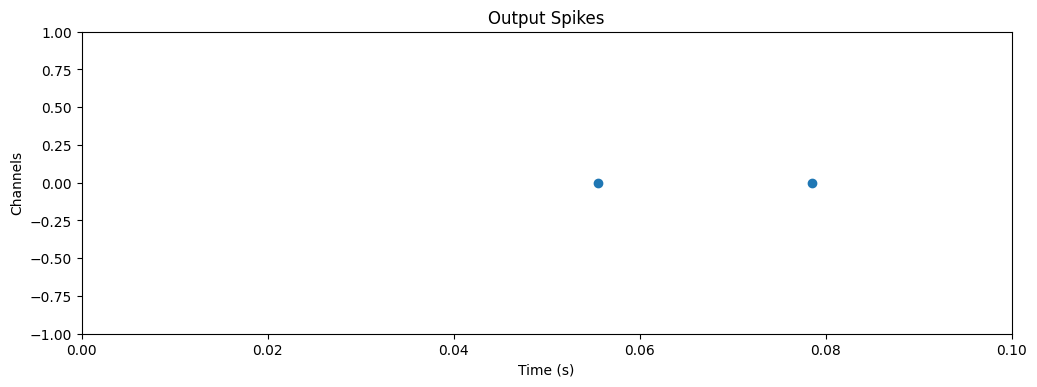

In [ ]:
plot_LIF_record(record_dict['1_LIFTorch'], dt=dt, Vth=Vth)

Lastly, the rate readout layer computes the firing rate by counting the number of spikes and dividing them by the duration of the input sample. Here two spikes are produced in 100 ms resulting in a firing rate of 20 Hz.

In [ ]:
print(rate_out)

tensor([[20.]], grad_fn=<DivBackward0>)


---
## Section 3: Define the Optimization Task

We want the neuron to fire at 50 Hz given the 200 Hz input. In order to arrive at this target firing rate, we need to define a loss function, such that minimising the loss will lead to our desired output rate.

### Section 3.1 : Target

Here we define the target firing rate.

In [ ]:
target = torch.tensor(50.0)

### Section 3.2 : Loss Function

We use Mean squared error (MSE), which is one of the most commonly used loss function for regression tasks in machine learning. The loss is given by the mean of the squared differences between true and predicted values for the rate of the neuron.

MSE Loss : $ l = (r - \hat{r})^ 2 $

In [ ]:
crit = MSELoss()
loss_trace = []

SNNs produce spike trains and therefore all quantities derived from that are discrete rather than continuous as in ANNs.

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/ann_snn.png width="1024">

Training SNNs therefore brings additional challenges over an ANN. For example, SNN activations are binary (spikes) and discontinuous, in contrast to the continuous real-valued activations of an ANN. This reduces the representational capacity of each activation.

Also, the SNN activation function has inconvienient and discontinuous gradients, and therefore leads to badly-shaped loss surfaces. If we want to apply gradient descent optimization, the process is in general

1. Initialize the weight with a random value
2. Compute the gradient of the loss with respect to weight
3. Slightly move to the opposite direction to the gradient
4. Repeat this until the process converges, and minimum loss achieved

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/gradient_descent.png width="416">

We can see from the loss surface that gradients are 0 everywhere, except where they are undefined (at the transitions). Therefore, we cannot apply a gradient-based optimization procedure to converge into the minimum loss.

100%|██████████| 500/500 [00:24<00:00, 20.38it/s]


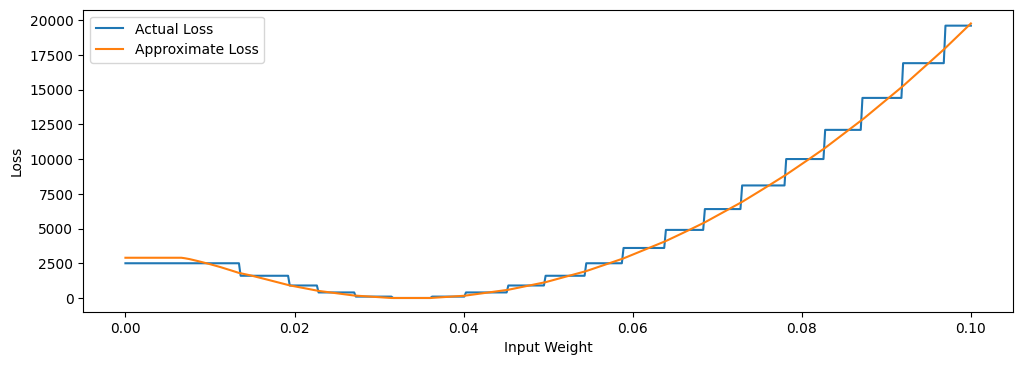

In [ ]:
#@title Section 3.3 : Loss Surface { display-mode: "form" }

_loss_trace = []
_grad_trace = []

W = np.linspace(0, .1, 500, dtype=np.float32)

# Sweep over the weights
for w in tqdm(W):
    # Redefine the model with a different input weight
    lin = LinearTorch((1, 1), weight = torch.tensor([[w]]), has_bias=False)
    model = Sequential(lin, lif, readout)

    # Simulate the network exactly with the same input
    model.reset_state()
    out, _, _ = model.evolve(spike_ts, record=True)
    
    # Calculate and record the loss
    loss = crit(target, out)
    _loss_trace.append(loss.item())

    # Error backpropagation
    # loss -> readout -> lif -> linear         
    loss.backward()    
    _grad_trace.append(model[0].weight.grad.item())

surrogate_loss = np.cumsum(np.array(_grad_trace).flatten()*(W[1]-W[0]))
surrogate_loss = surrogate_loss - np.min(surrogate_loss) + np.min(_loss_trace)

plt.figure()
plt.plot(W, _loss_trace, label = "Actual Loss")
plt.plot(W, surrogate_loss, label = "Approximate Loss")
plt.xlabel("Input Weight")
plt.ylabel("Loss")
plt.legend();

However, it's not the end of the world! There are several ways to overcome this, Rockpool uses a popular one: surrogate gradients. With this method, an approximate loss surface which we can execute a gradient-based optimization procedure can be obtained. For details, please refer to the bonus section : Surogate Gradient Method.

---
## Section 4 : Training a Spiking Neural Network

So far we have explored spiking rockpool modules and now we're ready to optimize our network. Let's first re-initialize the linear layer.

In [ ]:
# Reinitialize the weight matrix

# TODO : Change the weight to see what happens
# TODO : What happens if we initialize the input weights very close to 0?

# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[1.2]]),
    has_bias=False,
)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

### Section 4.1 : Training Loop

We are using the MSE loss and the Adam optimizer for training. The workflow is similar to the native `torch` API.

In [ ]:
# Configure the optimization
epochs = 1000
learning_rate = 1e-2

# Construct the optimizer
optim = Adam(model.parameters().astorch(), lr=learning_rate)

# Record the loss and parameters changes
param_trace = []
loss_trace = []

for i in tqdm(range(epochs)):

    # Reset the state variables: Vmem, Isyn, spikes
    model.reset_state()

    # Reset the optimizer
    optim.zero_grad()

    # Run model
    out, state, rec = model(spike_ts, record=True)

    # Calculate the MSE loss between expected rate and the target
    loss = crit(target, out)
    loss_trace.append(loss.item())

    # Early stopping criteria
    if loss == 0:
        break

    # Error backpropagation : readout -> LIF -> input
    loss.backward()

    # Update the network parameters
    optim.step()

    # Record the parameter change
    param_trace.append(model[0].weight.data.item())

 30%|███       | 305/1000 [00:13<00:30, 22.66it/s]


### Section 4.2 : Results

Let's check what happened during and after training. First we can see that the loss converges to zero. 

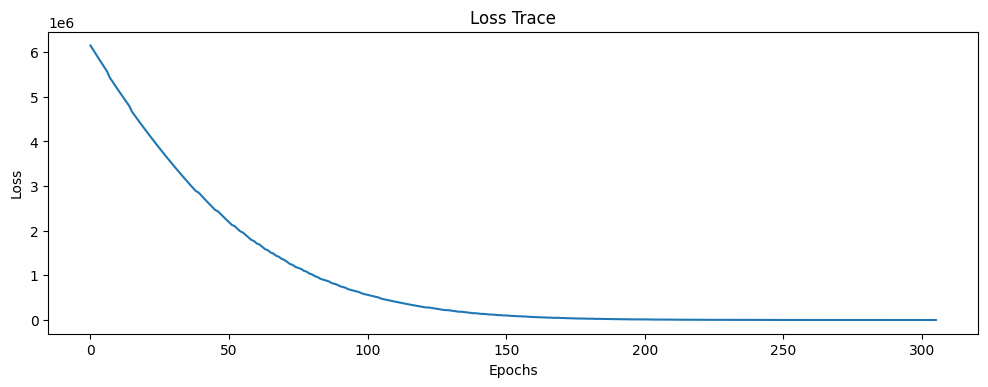

In [ ]:
plt.plot(loss_trace)
plt.title("Loss Trace")
plt.xlabel("Epochs")
plt.ylabel("Loss");

How did this happen? Inside the training loop, Adam continuously updated the weight parameter in the direction of the minimal loss.

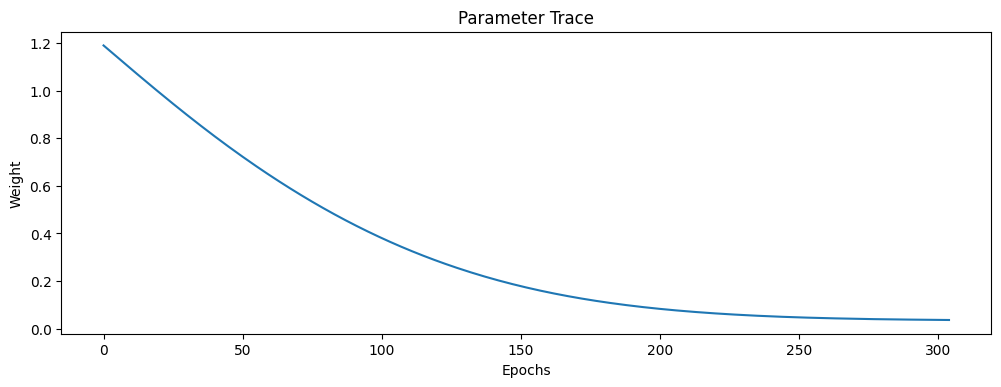

In [ ]:
plt.plot(param_trace)
plt.title("Parameter Trace")
plt.xlabel("Epochs")
plt.ylabel("Weight");

Finally, let's run the optimized module and prove that it expresses a firing rate of 50 Hz.

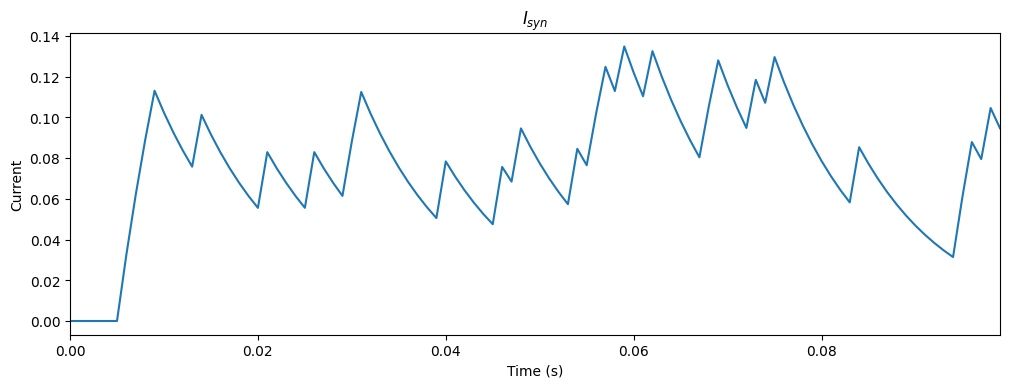

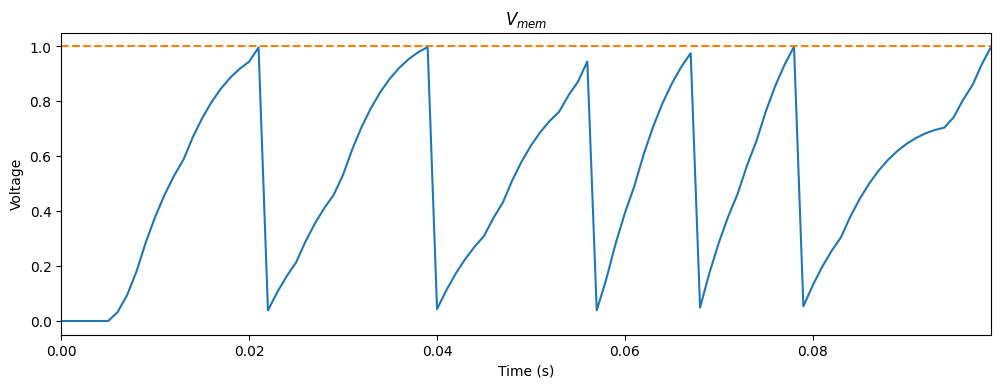

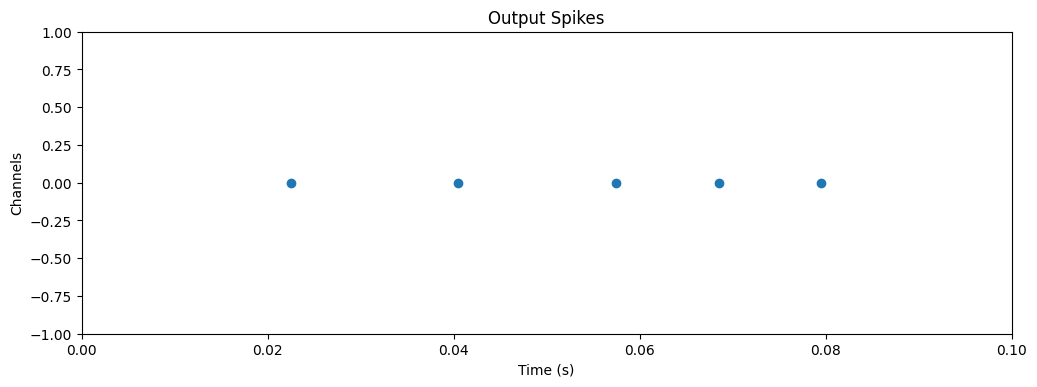

In [ ]:
model.reset_state()
out, state, rec = model(spike_ts, record=True)
plot_LIF_record(rec['1_LIFTorch'], dt=dt, Vth=Vth)

See that the rate reading is 50. 

In [ ]:
out.item()

50.0

---
# Conclusion

In this tutorial, we optimized a one-channel one-neuron spiking neuron to fire at 50 Hz given an input poisson spike train with a 200 Hz mean frequency. We explored the behavior of a torch-end Rockpool spiking module `LIFTorch`. We motivated the use of surrogate gradients to solve discontinuity issues of gradient-based optimization when training SNNs and showed that it works. In the next step we will use these techniques to accomplish a more complex task. Stay tuned! 


---
# [BONUS] Surrogate Gradient Method
 

In the surrogate gradient method, the forward pass through a spiking neuron (top) uses a discontinuous spike generation function. The backwards pass (orange) uses a surrogate neuron (bottom, dashed); both neurons share a common weight $w$. The error $x^*-y$ is computed based on the surrogate output, and used to compute an error gradient with respect to the weights, $\nabla w$.

<img src=https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/3.%20Training%20SNNs%20from%20scratch/figures/surrogate_neuron.png width="600">

*Figure obtained from https://medium.com/neuromorphic-intelligence/putting-the-neural-back-into-networks-7a70bd267610*

## LIFTorch Forward Pass

The `LIFTorch` neuron produces a spike event if the membrane potential $V_{mem}$ is above its threshold $V_{th}$. We can express this by using a Heaviside function as the neuron activation function in the forward pass:

$y = H(V_{mem}, V_{th}) = V_{mem} > V_{th}$.

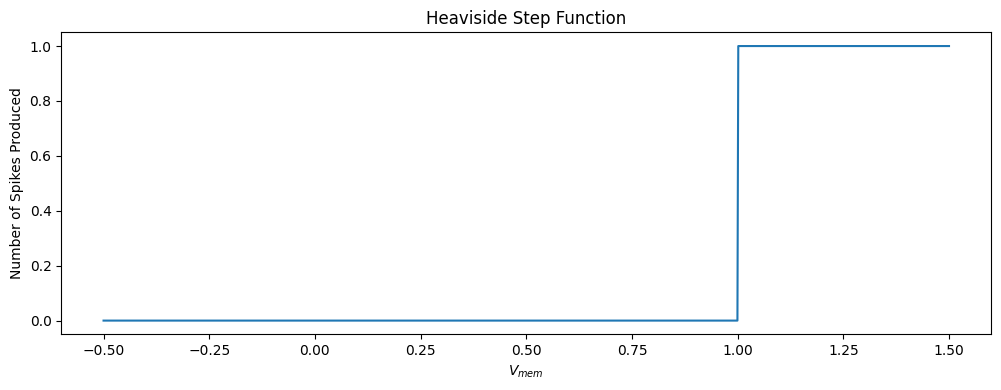

In [ ]:
x = torch.linspace(-0.5, 1.5, 1000, requires_grad=True)

# Function
step_pwl = StepPWL.apply
y = step_pwl(x, torch.tensor(1.0), torch.tensor(1.0), torch.tensor(float("inf")))

# Plot
plt.plot(x.detach(), y.detach())
plt.title("Heaviside Step Function")
plt.xlabel("$V_{mem}$")
plt.ylabel("Number of Spikes Produced");

## LIFTorch Backward Pass

If we compute the gradient of y with respect to x, we would see something different than the gradient of the heaviside step function, namely the gradient of the surrogate neuron's transfer function


In [ ]:
# [IMPORTANT] Run this line just once!
y.backward(x)

In order to observe the surrogate neuron's transfer function, we can integrate the gradient calculated.

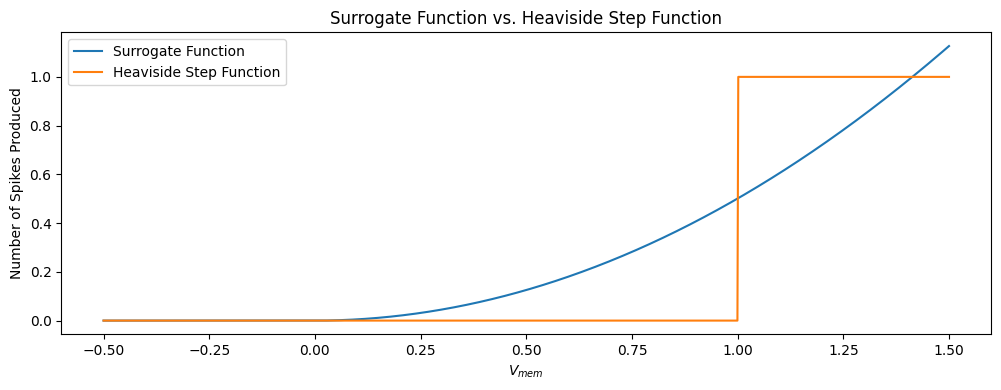

In [ ]:
surrogate = np.cumsum(x.grad.detach().flatten()*(x[1]-x[0]).detach().item())
plt.plot(x.detach(), surrogate, label = "Surrogate Function")
plt.plot(x.detach(), y.detach(), label = "Heaviside Step Function")
plt.title("Surrogate Function vs. Heaviside Step Function")
plt.legend();
plt.xlabel("$V_{mem}$")
plt.ylabel("Number of Spikes Produced");

## Approximate Loss Surface

If we look at the loss surface calculated using the surrogate gradient approach, we see that it's differentiable! It allows us to use gradient-based optimization and minimize the loss.

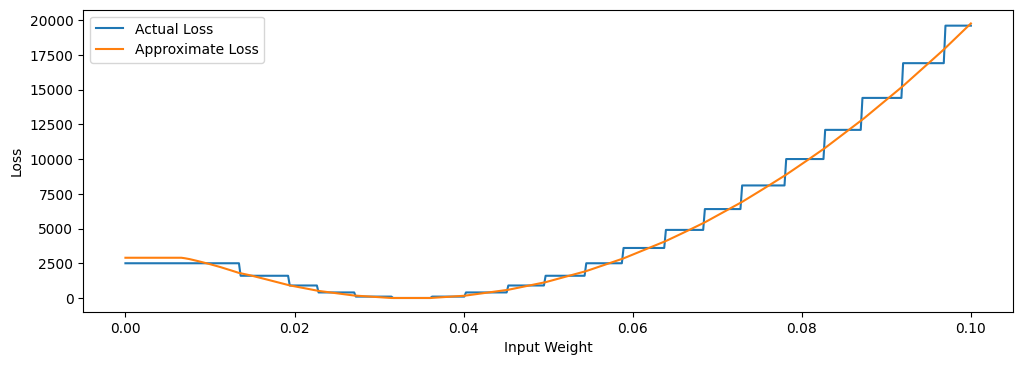

In [ ]:
surrogate_loss = np.cumsum(np.array(_grad_trace).flatten()*(W[1]-W[0]))
surrogate_loss = surrogate_loss - np.min(surrogate_loss) + np.min(_loss_trace)

plt.figure()
plt.plot(W, _loss_trace, label = "Actual Loss")
plt.plot(W, surrogate_loss, label = "Approximate Loss")
plt.xlabel("Input Weight")
plt.ylabel("Loss")
plt.legend();


## Further Reading

[1] J. Lee, T. Delbru ̈ck, and M. Pfeiffer, “Training deep spiking neural networks using backpropagation,” Frontiers in Neuroscience, vol. 10, 2016.

[2] E. O. Neftci, H. Mostafa, and F. Zenke, “Surrogate gradient learning in spiking neural networks: Bringing the power of gradient-based optimization to spiking neural networks,” IEEE Signal Processing Magazine, vol. 36, no. 6, pp. 51–63, 2019.
